In [1]:
#yahoo finance as data source
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-15,119.633331,120.083336,113.833336,117.016663,93.381660,11072223
2018-10-16,117.016663,119.099998,115.416664,117.433334,93.714172,10269687
2018-10-17,118.966667,121.416664,114.533333,115.116669,91.865410,13931499
2018-10-19,114.666664,119.583336,114.033333,114.766663,91.586105,14053947
2018-10-22,115.883331,117.750000,113.633331,114.099998,91.054100,10611888


In [7]:
len(data)

1236

In [8]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-09,122.400002,122.900002,120.900002,121.800003,121.800003,11378558
2023-10-10,122.000000,123.400002,121.849998,122.900002,122.900002,9862213
2023-10-11,123.250000,124.699997,123.050003,123.550003,123.550003,13202599
2023-10-12,123.550003,130.399994,123.550003,129.350006,129.350006,44500591
2023-10-13,128.899994,132.149994,128.000000,128.250000,128.250000,32376316


In [9]:
opn = data[['Open','Close']]

KeyError: "['close'] not in index"

<Axes: xlabel='Date'>

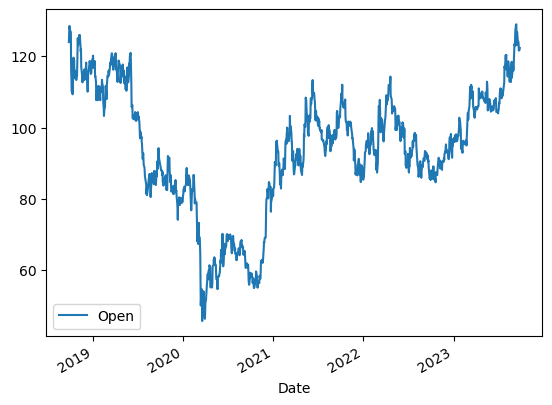

In [214]:
opn.plot()

In [215]:
import matplotlib.pyplot as plt

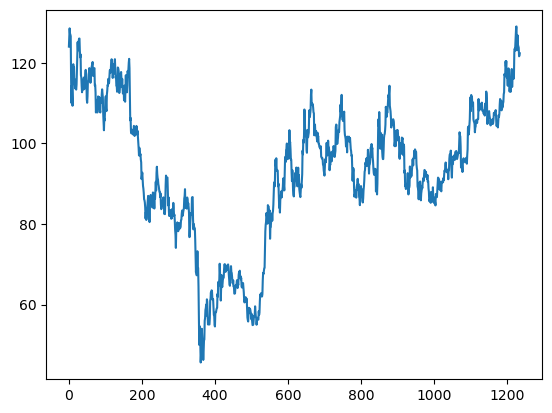

In [216]:
ds = opn.values
plt.plot(ds)

In [217]:
import numpy as np

In [218]:
from sklearn.preprocessing import MinMaxScaler

In [219]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [220]:
len(ds_scaled), len(ds)

(1236, 1236)

In [221]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [222]:
train_size,test_size

(865, 371)

In [223]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]
len(ds_train),len(ds_test)

(865, 371)

In [224]:
len(ds_train),len(ds_test)

(865, 371)

In [225]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [226]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [227]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [228]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [229]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [230]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [231]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_22 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [232]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)
model.history.history.keys()

Epoch 1/10
12/12 [==============================] - 6s 186ms/step - loss: 0.0788 - val_loss: 0.0249
Epoch 2/10
12/12 [==============================] - 1s 105ms/step - loss: 0.0146 - val_loss: 0.0043
Epoch 3/10
12/12 [==============================] - 1s 106ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 4/10
12/12 [==============================] - 1s 105ms/step - loss: 0.0061 - val_loss: 0.0038
Epoch 5/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 6/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 7/10
12/12 [==============================] - 1s 107ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 8/10
12/12 [==============================] - 1s 108ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 9/10
12/12 [==============================] - 1s 111ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 10/10
12/12 [==============================] - 1s 107ms/step - loss: 0.0043 - val_loss: 0.0021

dict_keys(['loss', 'val_loss'])

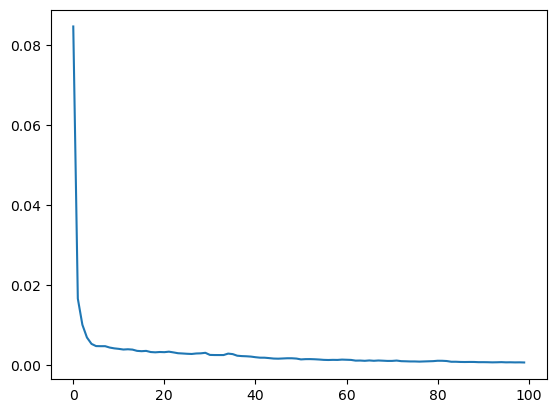

In [ ]:
loss = model.history.history['loss']
plt.plot(loss)
plt.show()


In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 22ms/step


In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

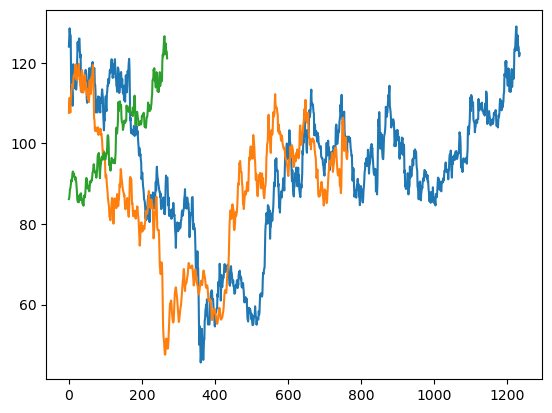

In [ ]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
test = np.vstack((train_predict,test_predict))

371

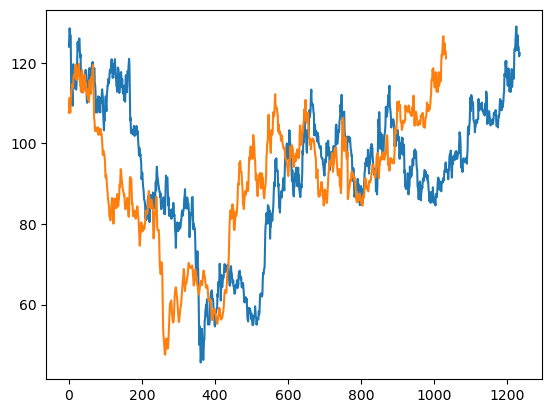

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)
len(ds_test)

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]
fut_inp = fut_inp.reshape(1,-1)
fut_inp.shape

(1, 101)

In [ ]:
tmp_inp = list(fut_inp)

#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)
print(len(lst_output))
len(fut_inp)

[[0.9114201068878174], [0.9056883454322815], [0.8999803066253662], [0.8946331143379211], [0.8894165754318237], [0.8843500018119812], [0.8794332146644592], [0.8746451139450073], [0.8699577450752258], [0.8653459548950195], [0.8607898950576782], [0.8562777638435364], [0.8518049120903015], [0.8473713397979736], [0.8429811000823975], [0.8386388421058655], [0.8343506455421448], [0.8301207423210144], [0.8259525299072266], [0.8218477368354797], [0.8178071975708008], [0.8138301968574524], [0.8099151253700256], [0.8060598373413086], [0.8022621870040894], [0.7985200881958008], [0.7948309779167175], [0.791192889213562], [0.7876043319702148], [0.7840631604194641]]
30


1

In [ ]:
len(ds_scaled)

1236

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

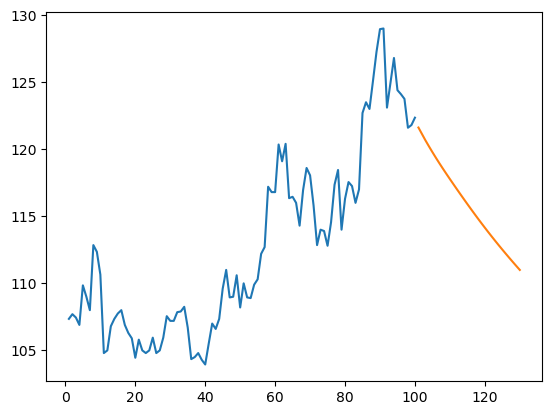

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1136:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()
len(ds_new)

1236

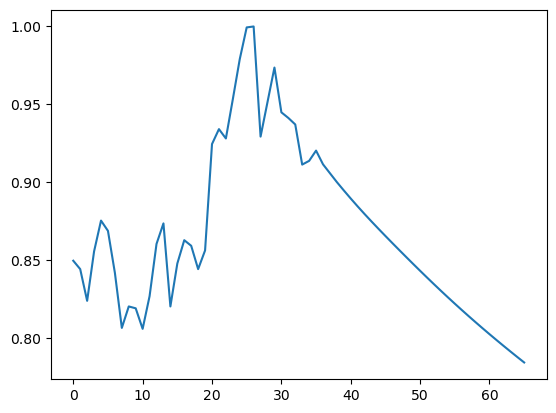

In [ ]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

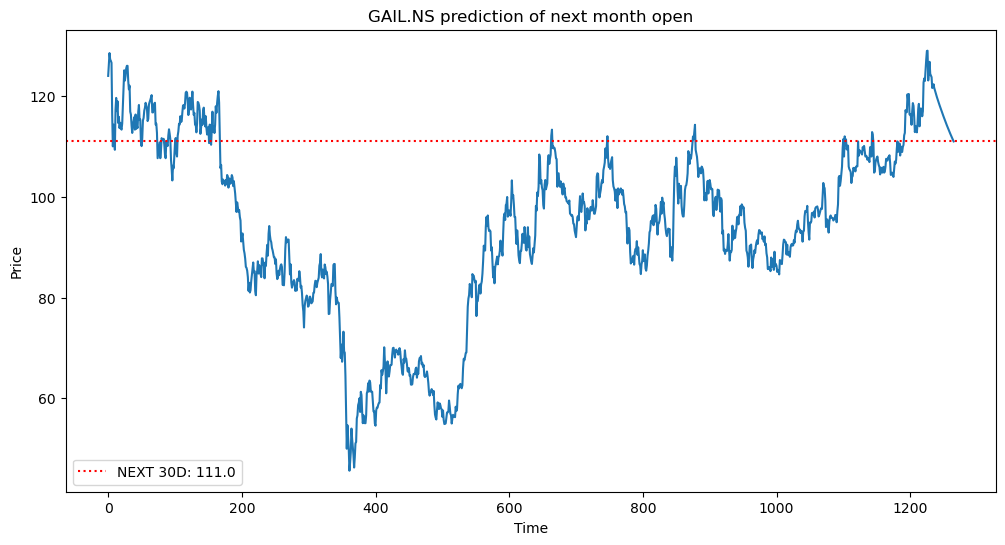

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.figure(figsize=(12, 6))
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()